<a href="https://colab.research.google.com/github/IronmanBD/LeNet-5-Implementation/blob/main/LeNet_5_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [24]:
transform = transforms.ToTensor()

In [25]:
batch_size= 16

trainset = datasets.MNIST(root='./data', train=True,
                                     download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle = True,
                                          num_workers=2
                                         )

testset = datasets.MNIST(root='./data', train=False,
                                    download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2
                                        )

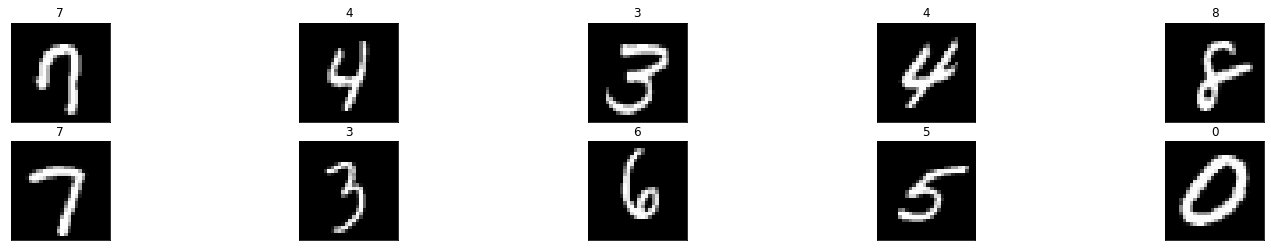

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1=nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2=nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [29]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 256]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
if torch.cuda.is_available():
    model.cuda()

In [35]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs
train_losses=[]
for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in trainloader:
        # clear the gradients of all optimized variables
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(images)
        # calculate the loss
        loss = criterion(output,labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    train_losses.append(train_loss)
    if epoch%2==0: 
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch, 
          train_loss
          ))

Epoch: 0 	Training Loss: 0.205221
Epoch: 2 	Training Loss: 0.179059
Epoch: 4 	Training Loss: 0.158787
Epoch: 6 	Training Loss: 0.141228
Epoch: 8 	Training Loss: 0.128769


Text(0, 0.5, 'loss')

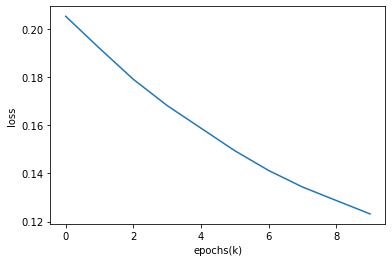

In [46]:
plt.plot(train_losses)
plt.xlabel('epochs(k)')
plt.ylabel('loss')

In [44]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for images, labels in testloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    images=images.to(device)
    labels=labels.to(device)
    output = model(images)
    # calculate the loss
    loss = criterion(output, labels)
    # update test loss 
    test_loss += loss.item()*images.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.113086

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 96% (993/1032)
Test Accuracy of     3: 95% (964/1010)
Test Accuracy of     4: 96% (943/982)
Test Accuracy of     5: 97% (867/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 96% (995/1028)
Test Accuracy of     8: 94% (923/974)
Test Accuracy of     9: 93% (948/1009)

Test Accuracy (Overall): 96% (9660/10000)
